# K Means From Scratch

## The Basic Idea

Given a dataset where each observed example has a set of features, but has
**no** labels. What can we do?

One task we can perform on a data set with no labels is to find groups of data in our dataset
which are similar to one another -- called clusters.

K Means is a clustering algorithm. It stores k centroids that it uses to define clusters. A point
is considered to be in a particular cluster if it is closer to that cluster's centroid that any other
centroid.

## The Algorithm

We are given training sets $\{ x^1, x^2,..., x^m \}$, and want to group the data into a few
cohesive "clusters". Here, we are given feature vectors for each data point $x^i \in\mathbb{R}^n$
as usual. Our goal is to predict k centroids **and** a label $c^i$ for each datapoint.

1. Initialize **cluster centroids** $\mu_1, \mu_2,...,\mu_k\in\mathbb{R}^n$ randomly.
2. Repeat until convergence:

$$
\text{Set } c^i := arg \min_{j} \Vert x^i - \mu_j\Vert ^2 \text{ }\text{  for every i}
$$

$$
\text{Set } \mu_j := \frac{\sum_{i=1}^m \chi_{\{c^i = j\}}x^i}{\sum_{i=1}^m \chi_{\{c^i = j\}}} \text{ }\text{  for every j}
$$


We can write the algorithm using 5 key steps:
1. randomly select centroids.
2. calculate distance at each point and assign each point to cluster.
3. calculate average of the assigned point.
4. move centroid to the new position.
5. repeat steps 2-4 until cluster assignment is not changed.

## Implementation of steps from 1 to 5

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets._samples_generator import make_blobs

In [2]:
MAX_ITERATIONS = 300

In [3]:
# step 1
def get_random_centroids(dataset, k):
    temp = []
    n_features = len(dataset[0])
    for i in range(n_features):
        rand_pos = np.random.randint(0.8*np.min(dataset[:, i]), 0.8*np.max(dataset[:, i]),size=k)
        temp.append(rand_pos)

    c_positions = np.array(temp).T

    return c_positions
        

In [4]:
def kmeans(dataset, centroids, k):
    n = len(dataset)
    clusters = np.zeros(n)
    iterations = 0
    old_centroids = None

    # step 5
    while not should_stop(old_centroids, centroids, iterations):
        for i in range(n):
            # step 2
            distances = [get_dist(dataset[i],c) for c in centroids]
            cluster = np.argmin(distances)
            clusters[i] = cluster
            
        old_centroids = deepcopy(centroids)

        # step 3-4
        for j in range(k):
            points = [dataset[i] for i in range(n) if clusters[i] == j]
            centroids[j] = np.mean(points, axis=0)
        iterations += 1

    return centroids, clusters

def get_dist(a, b):
    return np.linalg.norm(a - b)

def should_stop(old_centroids, centroids, iterations):
    if iterations > MAX_ITERATIONS:
        return True
    return np.array_equal(old_centroids,centroids)


### Let's Make Some Data

In [5]:
num_of_centroids = 4
dataset, _ = make_blobs(n_samples=5000, centers=num_of_centroids, n_features=2, random_state=195)

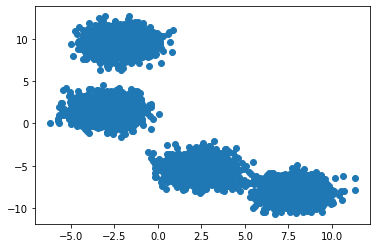

In [6]:
plt.scatter(dataset[:,0], dataset[:, 1])
plt.show()

In [7]:
n_features = 2
c_positions = get_random_centroids(dataset, num_of_centroids) 

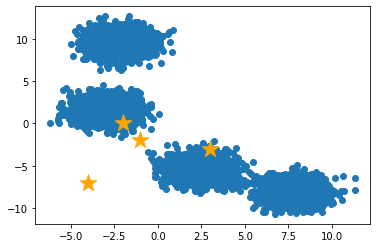

In [8]:
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.scatter(c_positions[:, 0], c_positions[:, 1], marker='*', s=300, c='orange')
plt.show()

## Apply K-Means

In [9]:
new_clusters, clusters_points = kmeans(dataset, c_positions, num_of_centroids)

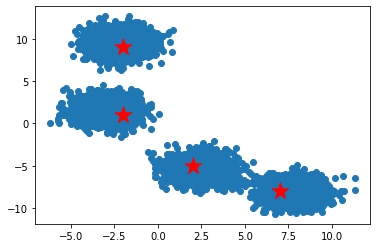

In [10]:
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.scatter(new_clusters[:, 0], new_clusters[:, 1], marker='*', s=300, c='r')
plt.show()

In [11]:
def plot_in_col(x, number_of_clusters, p, new_clusters):
    for i in range(number_of_clusters):
        col_points = np.array([x[n] for n in range(len(x)) if p[n] == i])
        plt.scatter(col_points[:, 0], col_points[:, 1], s=10)
    plt.scatter(new_clusters[:, 0], new_clusters[:, 1], marker='*', s=300, c='w')
    plt.show()

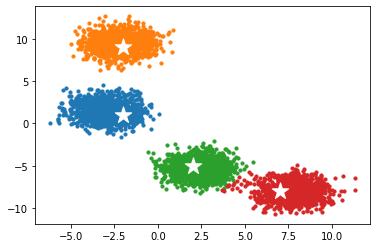

In [12]:
plot_in_col(dataset, num_of_centroids, clusters_points, new_clusters)

## Expectation Maximization

Note that K-Means is really just the Expectation Maximization algorithm applied to a particular
naive bayes model.

In the classic naive bayes model with a class variable which can take on discrete values
(with domain size k) and a set of feature variables, each of which can take on a continuous value. 
The conditional probability distribution $P(f_i=x | C = c)$ is going to be slightly different than
usual. Instead of storing this conditional probability as a table, we are going to store it a single
normal gaussian distribution, with its own mean and a standard deviation of 1. Specifically, this means
that: $P(f_i=x| C=c)\sim\mathcal{N}({\mu_{c,i},1)}$.

Remember that the whole goal of Naive Bayes to to find $P(y|x)$. $P(y|x)$ is proportional to 
$P(x|y)*P(y)$, so we need to figure out $P(x|y)$.

Learning the values of $\mu_{c,i}$ is given a dataset with assigned values to the features but not the 
class variables is provably identical to running k-means on that dataset.

Since we don't have the given "correct" classes for each observation, let's apply an EM algorithm approach 
to finding this $\mu_{c,i}$. Remember, EM starts with randomly initializing model parameters, 
and then repeats a two-step process of (E) assigning values to the unknown variables based of the parameters, 
and (M) calculating the parameters based off the data.


1. Come up with our unknown value (in this case the outcome it corresponds to), given the data. It turns out the best estimate for finding our unknown means is to use Euclidean distance, or just taking the mean. In other words, this is to say "for each point, find the mean that it's closer to."
2. Come up with the best parameter estimates based off the fact that you now have the data and the "guessed" outcomes from step 1. Turns out, the best estimate you can have for these parameters (MLE) is just the mean.
3. Repeat 1 and 2 until convergence.